In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from itertools import product
from mpl_toolkits.mplot3d import Axes3D  # 3D projection
import numpy as np

In [80]:
# ----------------------------
# Van der Pol System (device-safe)
# ----------------------------
def vdp(y, mu=1.0):
    return torch.stack([
        y[1],
        mu * (1 - y[0]**2) * y[1] - y[0]
    ]).to(y)

# ----------------------------
# General RK Integrator (Explicit & Implicit)
# ----------------------------
def rk_apply(butcher, x, dt, f, max_iter=10, tol=1e-8):
    A = torch.tensor(butcher['A'], dtype=x.dtype, device=x.device)
    b = torch.tensor(butcher['b'], dtype=x.dtype, device=x.device)

    s = len(b)
    d = x.shape[0]
    k = torch.zeros((s, d), dtype=x.dtype, device=x.device)

    for i in range(s):
        k_i = k[i].clone()

        def G(ki_guess):
            weighted_sum = sum(A[i, j] * (ki_guess if j == i else k[j]) for j in range(s))
            return f(x + dt * weighted_sum)

        for _ in range(max_iter):
            ki_new = G(k_i)
            if torch.norm(ki_new - k_i) < tol:
                break
            k_i = ki_new

        k[i] = k_i

    x_next = x + dt * torch.sum(b.view(-1, 1) * k, dim=0)
    return k, x_next

# ----------------------------
# Training Data Generation
# ----------------------------
def generate_training_data(func, y0, t0, t_end, N, butcher, mu=1.0, M = 10, device="cpu"):
    """
    Integrate using rk_apply and collect (x_n, k_n) pairs for NN training.
    """
    dt = (t_end - t0) / N
    x = y0.to(device)
    d = x.shape[0]
    s = len(butcher['b'])

    X = torch.zeros((N, d), dtype=torch.float32, device=device)
    K = torch.zeros((N, s, d), dtype=torch.float32, device=device)

    for n in range(N):
        X[n] = x
        k, x_next = rk_apply(butcher, x, dt/M, lambda y: func(y, mu=mu))
        for i in range(M-1):
            k, x_next = rk_apply(butcher, x_next, dt/M, lambda y: func(y, mu=mu))
        K[n] = k
        x = x_next

    return X, K

In [81]:
# Generate training data
X, K = generate_training_data(vdp, x0, t0=0.0, t_end=5, N=10000, butcher=rk4, device=device)

In [82]:
# ----------------------------
# Neural Network RK Stage Predictor
# ----------------------------
class NeuralRK(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, num_layers=3, dt=0.1, output_dim=2, butcher=None):
        super().__init__()
        if butcher is None:
            butcher = {
                'A': [
                    [0.0, 0.0, 0.0, 0.0],
                    [0.5, 0.0, 0.0, 0.0],
                    [0.0, 0.5, 0.0, 0.0],
                    [0.0, 0.0, 1.0, 0.0]
                ],
                'b': [1/6, 1/3, 1/3, 1/6],
                'c': [0.0, 0.5, 0.5, 1.0]
            }
        self.butcher = butcher
        self.s = len(butcher['b'])
        self.dt = dt
        self.output_dim = output_dim

        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers += [nn.Linear(hidden_dim, self.s * output_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.net(x)
        return out.view(batch_size, self.s, self.output_dim)

    def loss_fn(self, x, k_true):
        k_pred = self.forward(x)
        return F.mse_loss(k_pred, k_true)

# ----------------------------
# Main Training Loop
# ----------------------------
if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    rk4 = {
        'A': [
            [0.0, 0.0, 0.0, 0.0],
            [0.5, 0.0, 0.0, 0.0],
            [0.0, 0.5, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0]
        ],
        'b': [1/6, 1/3, 1/3, 1/6],
        'c': [0.0, 0.5, 0.5, 1.0]
    }

    # Create model and optimizer
    model = NeuralRK(hidden_dim=64, num_layers=3, dt=0.1, butcher=rk4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    

        # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 500000  # safety cap

    while True:
        idx = torch.randperm(X.size(0))
        x_batch = X[idx[:64]]
        k_batch = K[idx[:64]]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                    break
            else:
                wait = 0
                best_loss = loss_val

        epoch += 1
        if epoch >= max_epochs:
            print("Stopped early: max epochs reached.")
            break

Epoch    0: Loss = 1.720908
Epoch  100: Loss = 0.263191
Epoch  200: Loss = 0.012500
Epoch  300: Loss = 0.003593
Epoch  400: Loss = 0.001174
Epoch  500: Loss = 0.000486
Epoch  600: Loss = 0.000254
Epoch  700: Loss = 0.000171
Epoch  800: Loss = 0.000143
Epoch  900: Loss = 0.000098
Epoch 1000: Loss = 0.000105
Epoch 1100: Loss = 0.000078
Epoch 1200: Loss = 0.000063
Epoch 1300: Loss = 0.000044
Epoch 1400: Loss = 0.000040
Epoch 1500: Loss = 0.000040
Epoch 1600: Loss = 0.000030
Epoch 1700: Loss = 0.000032
Epoch 1800: Loss = 0.000030
Epoch 1900: Loss = 0.000026
Epoch 2000: Loss = 0.000027
Epoch 2100: Loss = 0.000021
Epoch 2200: Loss = 0.000016
Epoch 2300: Loss = 0.000014
Epoch 2400: Loss = 0.000011
Epoch 2500: Loss = 0.000013
Epoch 2600: Loss = 0.000016
Epoch 2700: Loss = 0.000016
Epoch 2800: Loss = 0.000011
Epoch 2900: Loss = 0.000013
Epoch 3000: Loss = 0.000009
Epoch 3100: Loss = 0.000010
Epoch 3200: Loss = 0.000010
Epoch 3300: Loss = 0.000043
Epoch 3400: Loss = 0.000128
Epoch 3500: Loss = 0

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"

rk4 = {
    'A': [
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0]
    ],
    'b': [1/6, 1/3, 1/3, 1/6],
    'c': [0.0, 0.5, 0.5, 1.0]
}

# Create model and optimizer
model = NeuralRK(hidden_dim=64, num_layers=3, dt=0.1, butcher=rk4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



# Training loop with convergence
min_epochs = 100
patience = 20
delta_tol = 1e-6

best_loss = float('inf')
wait = 0
epoch = 0
max_epochs = 500000  # safety cap

while True:
    idx = torch.randperm(X.size(0))
    x_batch = X[idx[:64]]
    k_batch = K[idx[:64]]

    optimizer.zero_grad()
    loss = model.loss_fn(x_batch, k_batch)
    loss.backward()
    optimizer.step()

    loss_val = loss.item()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

    if epoch >= min_epochs:
        if abs(loss_val - best_loss) < delta_tol:
            wait += 1
            if wait >= patience:
                print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                break
        else:
            wait = 0
            best_loss = loss_val

    epoch += 1
    if epoch >= max_epochs:
        print("Stopped early: max epochs reached.")
        break

Epoch    0: Loss = 2.905478
Epoch  100: Loss = 0.188924
Epoch  200: Loss = 0.009009
Epoch  300: Loss = 0.002434
Epoch  400: Loss = 0.000928
Epoch  500: Loss = 0.000435
Epoch  600: Loss = 0.000214
Epoch  700: Loss = 0.000196
Epoch  800: Loss = 0.000097
Epoch  900: Loss = 0.000106
Epoch 1000: Loss = 0.000083
Epoch 1100: Loss = 0.000071
Epoch 1200: Loss = 0.000047
Epoch 1300: Loss = 0.000055
Epoch 1400: Loss = 0.000029
Epoch 1500: Loss = 0.000026
Epoch 1600: Loss = 0.000031
Epoch 1700: Loss = 0.000020
Epoch 1800: Loss = 0.000020
Epoch 1900: Loss = 0.000019
Epoch 2000: Loss = 0.000013
Epoch 2100: Loss = 0.000015
Epoch 2200: Loss = 0.000012
Epoch 2300: Loss = 0.000011
Epoch 2400: Loss = 0.000008
Epoch 2500: Loss = 0.000007
Epoch 2600: Loss = 0.000008
Epoch 2700: Loss = 0.000012
Epoch 2800: Loss = 0.000012
Epoch 2900: Loss = 0.000010
Epoch 3000: Loss = 0.000016
Epoch 3100: Loss = 0.000009
Epoch 3200: Loss = 0.000006
Epoch 3300: Loss = 0.000008
Epoch 3400: Loss = 0.000011
Epoch 3500: Loss = 0

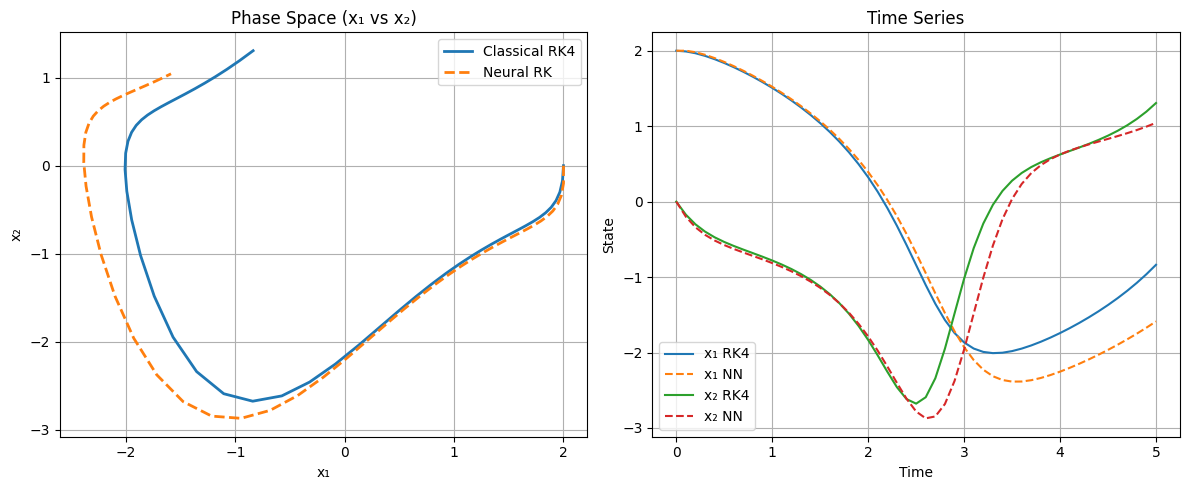

In [84]:
@torch.no_grad()
def rollout_neural_model(model, x0, steps, dt):
    """
    Use the trained NeuralRK model to generate a trajectory.
    """
    model.eval()
    x = x0.unsqueeze(0)  # shape: (1, 2)
    trajectory = [x.squeeze(0).cpu()]

    for _ in range(steps):
        k_pred = model(x)  # shape: (1, s, d)
        b = torch.tensor(model.butcher['b'], dtype=k_pred.dtype, device=k_pred.device).view(1, -1, 1)
        x_next = x + dt * torch.sum(b * k_pred, dim=1)
        x = x_next
        trajectory.append(x.squeeze(0).cpu())

    return torch.stack(trajectory)  # shape: (steps+1, d)

@torch.no_grad()
def rollout_rk4(x0, steps, dt, butcher, f):
    """
    Integrate using classical RK method.
    """
    x = x0.clone()
    trajectory = [x.cpu()]
    for _ in range(steps):
        k, x_next = rk_apply(butcher, x, dt, f)
        x = x_next
        trajectory.append(x.cpu())
    return torch.stack(trajectory)  # shape: (steps+1, d)

# === Parameters ===
dt = 0.1
steps = int(5/dt)
x0 = torch.tensor([2.0, 0.0], dtype=torch.float32).to(device)

# === Rollouts ===
traj_nn = rollout_neural_model(model, x0, steps, dt)
traj_rk = rollout_rk4(x0, steps, dt, rk4, vdp)

# === Plot ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(traj_rk[:, 0], traj_rk[:, 1], label="Classical RK4", lw=2)
plt.plot(traj_nn[:, 0], traj_nn[:, 1], '--', label="Neural RK", lw=2)
plt.title("Phase Space (x₁ vs x₂)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
t = torch.arange(steps + 1) * dt
plt.plot(t, traj_rk[:, 0], label="x₁ RK4")
plt.plot(t, traj_nn[:, 0], '--', label="x₁ NN")
plt.plot(t, traj_rk[:, 1], label="x₂ RK4")
plt.plot(t, traj_nn[:, 1], '--', label="x₂ NN")
plt.title("Time Series")
plt.xlabel("Time")
plt.ylabel("State")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [87]:
@torch.no_grad()
def evaluate_final_error(model, rk_func, butcher, f, x0_set, t_end, dt):
    """
    Compute the final-time error |NN(t_end) - RK(t_end)| for a batch of initial conditions.

    Args:
        model: Trained NeuralRK model
        rk_func: Classical RK function (e.g., rk_apply)
        butcher: RK Butcher tableau
        f: Vector field function (e.g., vdp)
        x0_set (Tensor): shape (batch_size, 2), initial conditions
        t_end (float): Final time
        dt (float): Step size

    Returns:
        errors (Tensor): shape (batch_size,), final state L2 error for each initial condition
    """
    model.eval()
    steps = int(t_end / dt)
    errors = []

    for x0 in x0_set:
        x0 = x0.to(model.net[0].weight.device)

        # Neural rollout
        traj_nn = rollout_neural_model(model, x0, steps, dt)
        x_nn_final = traj_nn[-1]

        # Classical RK rollout
        traj_rk = rollout_rk4(x0, steps, dt, butcher, f)
        x_rk_final = traj_rk[-1]

        # Compute final error
        err = torch.norm((x_nn_final - x_rk_final)/x_nn_final, p=2)
        errors.append(err.item())

    return torch.tensor(errors)


# Generate multiple initial conditions
n_ic = 20
x0_set = torch.stack([
    torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
    for _ in range(n_ic)
])

# Compute errors
errors = evaluate_final_error(
    model=model,
    rk_func=rk_apply,
    butcher=rk4,
    f=vdp,
    x0_set=x0_set,
    t_end=dt,
    dt=0.1
)

# Report
print("Mean final-time error:", errors.mean().item())
print("Max final-time error: ", errors.max().item())


Mean final-time error: 1.0779750347137451
Max final-time error:  8.210550308227539


In [88]:
# === Configurations ===
hidden_dims = [16, 32, 64]
num_layers_list = [1, 2, 3]
repeats = 1  # optional repeat per config

t_end = 10.0
dt = 0.1
steps = int(t_end / dt)
device = "cuda" if torch.cuda.is_available() else "cpu"

results = []

# Convergence criterion parameters:
max_epochs = 10000         # Maximum training epochs allowed
tol = 1e-6                 # Minimum loss improvement required
patience = 20              # Number of epochs without improvement to wait

# === Evaluation Initial Conditions ===
def sample_initial_conditions(n):
    return torch.stack([
        torch.tensor([torch.rand(1).item() * 4 - 2, torch.rand(1).item() * 4 - 2])
        for _ in range(n)
    ])

x0_eval = sample_initial_conditions(20).to(device)

# === Loop over Configurations ===
for hidden_dim, num_layers in product(hidden_dims, num_layers_list):
    print(f"Training model with hidden_dim={hidden_dim}, num_layers={num_layers}")
    

    # Initialize model and optimizer
    model = NeuralRK(hidden_dim=hidden_dim, num_layers=num_layers, dt=dt, butcher=rk4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    

  # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 500000  # safety cap

    while True:
        idx = torch.randperm(X.size(0))
        x_batch = X[idx[:64]]
        k_batch = K[idx[:64]]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                    break
            else:
                wait = 0
                best_loss = loss_val

        epoch += 1
        if epoch >= max_epochs:
            print("Stopped early: max epochs reached.")
            break
    
    print(f"Converged in {epoch} epochs with best loss {best_loss:.4e}")
    
    # Evaluate final error
    errors = evaluate_final_error(
        model=model,
        rk_func=rk_apply,
        butcher=rk4,
        f=vdp,
        x0_set=x0_eval,
        t_end=dt,
        dt=dt
    )
    
    results.append({
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "mean_error": errors.mean().item(),
        "max_error": errors.max().item()
    })

# === Save to CSV ===
df = pd.DataFrame(results)
df.to_csv("rk_nn_evaluation.csv", index=False)
print("\nSaved results to rk_nn_evaluation.csv")
display(df)


Training model with hidden_dim=16, num_layers=1
Epoch    0: Loss = 2.203716
Epoch  100: Loss = 0.705224
Epoch  200: Loss = 0.976010
Epoch  300: Loss = 0.693207
Epoch  400: Loss = 0.644326
Epoch  500: Loss = 0.552796
Epoch  600: Loss = 0.464420
Epoch  700: Loss = 0.414781
Epoch  800: Loss = 0.340609
Epoch  900: Loss = 0.317567
Epoch 1000: Loss = 0.224660
Epoch 1100: Loss = 0.185880
Epoch 1200: Loss = 0.156694
Epoch 1300: Loss = 0.083205
Epoch 1400: Loss = 0.057181
Epoch 1500: Loss = 0.044271
Epoch 1600: Loss = 0.046836
Epoch 1700: Loss = 0.022573
Epoch 1800: Loss = 0.018654
Epoch 1900: Loss = 0.015655
Epoch 2000: Loss = 0.009624
Epoch 2100: Loss = 0.006028
Epoch 2200: Loss = 0.005955
Epoch 2300: Loss = 0.004233
Epoch 2400: Loss = 0.003672
Epoch 2500: Loss = 0.003626
Epoch 2600: Loss = 0.003469
Epoch 2700: Loss = 0.003274
Epoch 2800: Loss = 0.003287
Epoch 2900: Loss = 0.002358
Epoch 3000: Loss = 0.003089
Epoch 3100: Loss = 0.003030
Epoch 3200: Loss = 0.001926
Epoch 3300: Loss = 0.002245


,hidden_dim,num_layers,mean_error,max_error
0,16,1,0.159147,0.734878
1,16,2,0.151070,0.567562
2,16,3,0.172777,0.790882
3,32,1,0.137520,0.581612
4,32,2,0.121570,0.494420
5,32,3,0.199714,0.960562
6,64,1,0.110055,0.451470
7,64,2,0.122597,0.421845
8,64,3,0.170236,0.785608


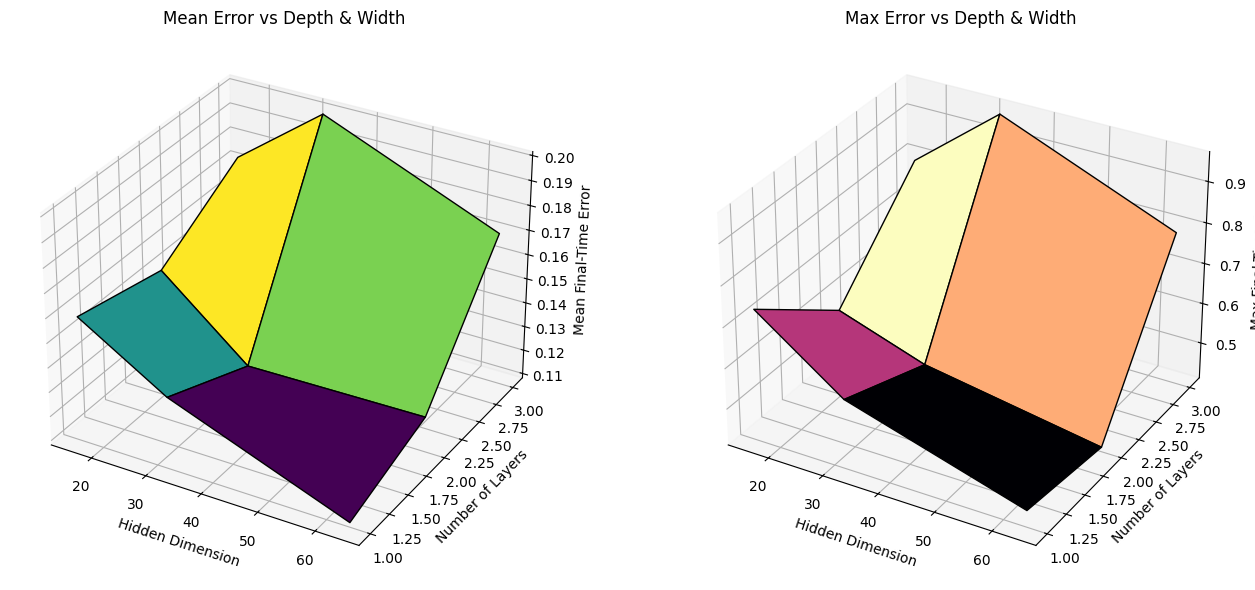

In [89]:
# === Load the CSV ===
df = pd.read_csv("rk_nn_evaluation.csv")

# === Prepare data ===
hidden_dims = sorted(df['hidden_dim'].unique())
num_layers = sorted(df['num_layers'].unique())

H, L = np.meshgrid(hidden_dims, num_layers)

# Reshape mean and max errors into 2D grid
mean_error_grid = np.zeros_like(H, dtype=np.float32)
max_error_grid = np.zeros_like(H, dtype=np.float32)

for i, nl in enumerate(num_layers):
    for j, hd in enumerate(hidden_dims):
        subset = df[(df['hidden_dim'] == hd) & (df['num_layers'] == nl)]
        mean_error_grid[i, j] = subset['mean_error'].mean()
        max_error_grid[i, j] = subset['max_error'].max()

# === Plot mean error surface ===
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(H, L, mean_error_grid, cmap='viridis', edgecolor='k')
ax1.set_xlabel("Hidden Dimension")
ax1.set_ylabel("Number of Layers")
ax1.set_zlabel("Mean Final-Time Error")
ax1.set_title("Mean Error vs Depth & Width")

# === Plot max error surface ===
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(H, L, max_error_grid, cmap='magma', edgecolor='k')
ax2.set_xlabel("Hidden Dimension")
ax2.set_ylabel("Number of Layers")
ax2.set_zlabel("Max Final-Time Error")
ax2.set_title("Max Error vs Depth & Width")

plt.tight_layout()
plt.show()


In [90]:
# Load results from CSV
df = pd.read_csv("rk_nn_evaluation.csv")

# Select model config with lowest mean error
best_row = df.loc[df['mean_error'].idxmin()]
best_hidden = int(best_row['hidden_dim'])
best_layers = int(best_row['num_layers'])

print(f"Best model: hidden_dim = {best_hidden}, num_layers = {best_layers}")


Best model: hidden_dim = 64, num_layers = 1


Training model for dt = 0.010
Epoch    0: Loss = 2.695499
Epoch  100: Loss = 0.966906
Epoch  200: Loss = 0.673649
Epoch  300: Loss = 0.737038
Epoch  400: Loss = 0.260875
Epoch  500: Loss = 0.165306
Epoch  600: Loss = 0.047548
Epoch  700: Loss = 0.035134
Epoch  800: Loss = 0.022114
Epoch  900: Loss = 0.011503
Epoch 1000: Loss = 0.013470
Epoch 1100: Loss = 0.009757
Epoch 1200: Loss = 0.008143
Epoch 1300: Loss = 0.006929
Epoch 1400: Loss = 0.005896
Epoch 1500: Loss = 0.005184
Epoch 1600: Loss = 0.003930
Epoch 1700: Loss = 0.003498
Epoch 1800: Loss = 0.003293
Epoch 1900: Loss = 0.002493
Epoch 2000: Loss = 0.001900
Epoch 2100: Loss = 0.001630
Epoch 2200: Loss = 0.001411
Epoch 2300: Loss = 0.000992
Epoch 2400: Loss = 0.000943
Epoch 2500: Loss = 0.000798
Epoch 2600: Loss = 0.000579
Epoch 2700: Loss = 0.000576
Epoch 2800: Loss = 0.000504
Epoch 2900: Loss = 0.000449
Epoch 3000: Loss = 0.000370
Epoch 3100: Loss = 0.000342
Epoch 3200: Loss = 0.000319
Epoch 3300: Loss = 0.000260
Epoch 3400: Loss =

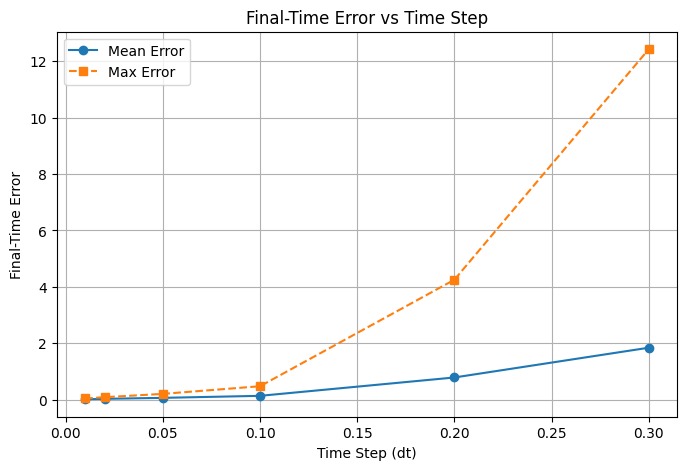

In [91]:
# === Define the best model from above ===
def build_best_model():
    return NeuralRK(hidden_dim=best_hidden, num_layers=best_layers, dt=0.1, butcher=rk4).to(device)

# === dt sweep setup ===
dt_values = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
errors_vs_dt = []

# === Evaluation initial conditions (same for all dts) ===
x0_eval = sample_initial_conditions(20).to(device)

# === Train once per dt and evaluate ===
X, K = generate_training_data(vdp, x0_train, t0=0.0, t_end=20.0, N=int(20.0/dt), butcher=rk4, device=device)
for dt in dt_values:
    print(f"Training model for dt = {dt:.3f}")

    # Build and train model
    model = NeuralRK(hidden_dim=best_hidden, num_layers=best_layers, dt=dt, butcher=rk4).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    x0_train = torch.tensor([2.0, 0.0], dtype=torch.float32).to(device)
    

    # Training loop with convergence
    min_epochs = 100
    patience = 20
    delta_tol = 1e-6

    best_loss = float('inf')
    wait = 0
    epoch = 0
    max_epochs = 500000  # safety cap

    while True:
        idx = torch.randperm(X.size(0))
        x_batch = X[idx[:64]]
        k_batch = K[idx[:64]]

        optimizer.zero_grad()
        loss = model.loss_fn(x_batch, k_batch)
        loss.backward()
        optimizer.step()

        loss_val = loss.item()

        if epoch % 100 == 0:
            print(f"Epoch {epoch:4d}: Loss = {loss_val:.6f}")

        if epoch >= min_epochs:
            if abs(loss_val - best_loss) < delta_tol:
                wait += 1
                if wait >= patience:
                    print(f"Converged after {epoch} epochs with loss {loss_val:.6f}")
                    break
            else:
                wait = 0
                best_loss = loss_val

        epoch += 1
        if epoch >= max_epochs:
            print("Stopped early: max epochs reached.")
            break

    # Evaluate error at t_end
    errors = evaluate_final_error(
        model=model,
        rk_func=rk_apply,
        butcher=rk4,
        f=vdp,
        x0_set=x0_eval,
        t_end=dt,
        dt=dt
    )

    errors_vs_dt.append({
        "dt": dt,
        "mean_error": errors.mean().item(),
        "max_error": errors.max().item()
    })

# === Convert to DataFrame & Plot ===
dt_df = pd.DataFrame(errors_vs_dt)
dt_df.to_csv("dt_vs_error.csv", index=False)
print("\nSaved results to dt_vs_error.csv")

plt.figure(figsize=(8, 5))
plt.plot(dt_df['dt'], dt_df['mean_error'], 'o-', label='Mean Error')
plt.plot(dt_df['dt'], dt_df['max_error'], 's--', label='Max Error')
plt.xlabel("Time Step (dt)")
plt.ylabel("Final-Time Error")
plt.title("Final-Time Error vs Time Step")
plt.grid(True)
plt.legend()
plt.show()
